In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
import ccxt
import seaborn as sns
import mplfinance as mpf

In [29]:
def get_n_columns(df, columns, n=1):
    dt = df.copy()
    for col in columns:
        dt["n"+str(n)+"_"+col] = dt[col].shift(n)
    return dt

def get_min_max(df, column_name, candle_min_window=3):
    originals_columns = list(df.columns.copy())
    originals_columns.append(column_name+"_top")
    originals_columns.append(column_name+"_bottom")
    dt = df.copy()
    dt[column_name+"_bottom"] = 1
    dt[column_name+"_top"] = 1

    for i in range(1, candle_min_window + 1, 1):
        dt = get_n_columns(dt, [column_name], i)
        dt = get_n_columns(dt, [column_name], -i)

        dt.loc[(dt["n" + str(-i) + "_" + column_name] < dt[column_name]) | (dt["n" + str(i) + "_" + column_name] < dt[column_name]), column_name+"_bottom"] = 0
        dt.loc[(dt["n" + str(-i) + "_" + column_name] > dt[column_name])  | (dt["n" + str(i) + "_" + column_name] > dt[column_name]), column_name+"_top"] = 0
    dt = dt.loc[:,originals_columns]

    return dt

def get_df_top_divergence(df_top, df_top_indicator, indicator_name, base_column="close", top_concordance=True, max_period_check=100):
    top_scopes = []
    for index, row in df_top.iterrows():
        min_scope = -1000000
        min_window_diff = 10
        top_indicator_index = list(df_top_indicator["iloc"])
        try:
            current_df = df_top.copy().loc[df_top.index > index]
            base_point_date = row["date"]
            base_point_iloc = row["iloc"]
            base_point_value = row[base_column]
            base_point_indicator_value = row[indicator_name]
            for current_row in current_df.to_dict(orient="records"):
                scope = (current_row[base_column] - base_point_value) / (current_row["iloc"] - base_point_iloc)
                if base_point_iloc + max_period_check < current_row["iloc"]:
                    break
                elif (current_row["iloc"] - base_point_iloc < min_window_diff):
                    min_scope = scope
                    continue
                elif (scope < min_scope):
                    continue
                else:
                    min_scope = scope
                    if top_concordance == False or ((current_row["iloc"] in top_indicator_index) and (base_point_iloc in top_indicator_index)):
                        indicator_scope = (current_row[indicator_name] - base_point_indicator_value) / (current_row["iloc"] - base_point_iloc)
                        top_scopes.append({
                            "start_date": base_point_date,
                            "end_date": current_row["date"],
                            "start_iloc": base_point_iloc,
                            "end_iloc": current_row["iloc"],
                            "start_value": base_point_indicator_value,
                            "end_value": current_row["close"],
                            "scope":scope,
                            "start_indicator_value": base_point_value,
                            "end_indicator_value": current_row["rsi"],
                            "indicator_scope": indicator_scope
                        })
        except:
            pass
    df_top_scopes = pd.DataFrame(top_scopes)
    return {
        "top_bull_div": df_top_scopes.loc[((df_top_scopes["scope"] > 0) & (df_top_scopes["indicator_scope"] < 0))],
        "top_bear_div": df_top_scopes.loc[((df_top_scopes["scope"] < 0) & (df_top_scopes["indicator_scope"] > 0))]
    } 

def get_df_bottom_divergence(df_bottom, df_bottom_indicator, indicator_name, base_column="close", bottom_concordance=True, max_period_check=100):
    bottom_scopes = []
    for index, row in df_bottom.iterrows():
        max_scope = 1000000
        min_window_diff = 10
        bottom_indicator_index = list(df_bottom_indicator["iloc"])
        try:
            current_df = df_bottom.copy().loc[df_bottom.index > index]
            base_point_date = row["date"]
            base_point_iloc = row["iloc"]
            base_point_value = row[base_column]
            base_point_indicator_value = row[indicator_name]
            for current_row in current_df.to_dict(orient="records"):
                scope = (current_row[base_column] - base_point_value) / (current_row["iloc"] - base_point_iloc)
                if base_point_iloc + max_period_check < current_row["iloc"]:
                    break
                elif (current_row["iloc"] - base_point_iloc < min_window_diff):
                    max_scope = scope
                    continue
                elif (scope > max_scope):
                    continue
                else:
                    max_scope = scope
                    if bottom_concordance == False or ((current_row["iloc"] in bottom_indicator_index) and (base_point_iloc in bottom_indicator_index)):
                        indicator_scope = (current_row[indicator_name] - base_point_indicator_value) / (current_row["iloc"] - base_point_iloc)
                        bottom_scopes.append({
                            "start_date": base_point_date,
                            "end_date": current_row["date"],
                            "start_iloc": base_point_iloc,
                            "end_iloc": current_row["iloc"],
                            "start_value": base_point_indicator_value,
                            "end_value": current_row[indicator_name],
                            "scope":scope,
                            "start_indicator_value": base_point_value,
                            "end_indicator_value": current_row[base_column],
                            "indicator_scope": indicator_scope
                        })
        except:
            pass
    df_bottom_scopes = pd.DataFrame(bottom_scopes)
    return {
        "bottom_bull_div": df_bottom_scopes.loc[((df_bottom_scopes["scope"] > 0) & (df_bottom_scopes["indicator_scope"] < 0))],
        "bottom_bear_div": df_bottom_scopes.loc[((df_bottom_scopes["scope"] < 0) & (df_bottom_scopes["indicator_scope"] > 0))]
    } 

def plot_div(df, div_row, indicator_name, window_detection, add_candles_number=20, show_print=False):
    start_iloc = div_row["start_iloc"]
    end_iloc = div_row["end_iloc"]
    df_current_divergence = df.iloc[start_iloc-10:end_iloc+add_candles_number]
    s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 6})
    fig = mpf.figure(1, figsize=(20, 15), style=s) 
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2, sharex=ax1)
    ap0 = [
        mpf.make_addplot(df_current_divergence[indicator_name], color='green', panel=0, title=indicator_name, ax=ax2),
    ]
    mpf.plot(df_current_divergence, type='candle', ax=ax1, addplot=ap0)
    fig.subplots_adjust(hspace=0.2)
    # ax1.tick_params(labelbottom=False)
    ax2.tick_params(labelbottom=False)
    ax1.yaxis.set_label_position('left')
    ax1.yaxis.tick_left()
    index_top_close = [start_iloc, end_iloc]
    index_top_indicator = [start_iloc, end_iloc]
    ax1.scatter(x=(index_top_close - df_current_divergence.iloc[0]["iloc"]), y=df.iloc[index_top_close]["close"], s=200, c='orange', zorder=2)
    ax2.scatter(x=(index_top_indicator - df_current_divergence.iloc[0]["iloc"]), y=df.iloc[index_top_indicator][indicator_name], s=200, c='orange', zorder=2)
    ax1.plot((index_top_close - df_current_divergence.iloc[0]["iloc"]), df.iloc[index_top_close]["close"], linestyle="--")
    ax2.plot((index_top_indicator - df_current_divergence.iloc[0]["iloc"]), df.iloc[index_top_indicator][indicator_name], linestyle="--")
    ax1.scatter(x=([df.iloc[end_iloc+window_detection]["iloc"] - df_current_divergence.iloc[0]["iloc"]]), y=[df.iloc[end_iloc+window_detection]["close"]], s=100, c='blue', zorder=2)
    plt.show()
    detected_price = df.iloc[end_iloc + window_detection]["close"]
    candle_evol_1 = (df.iloc[end_iloc + window_detection + 1]["close"] - detected_price) / detected_price
    candle_evol_3 = (df.iloc[end_iloc + window_detection + 3]["close"] - detected_price) / detected_price
    candle_evol_5 = (df.iloc[end_iloc + window_detection + 5]["close"] - detected_price) / detected_price
    candle_evol_10 = (df.iloc[end_iloc + window_detection + 10]["close"] - detected_price) / detected_price
    candle_evol_20 = (df.iloc[end_iloc + window_detection + 20]["close"] - detected_price) / detected_price
    candle_evol_50 = (df.iloc[end_iloc + window_detection + 50]["close"] - detected_price) / detected_price
    candle_evol_100 = (df.iloc[end_iloc + window_detection + 100]["close"] - detected_price) / detected_price
    if show_print == True:
        print(f"Evolution 1 candle after divergence detection: {round(candle_evol_1 * 100, 2)}%")
        print(f"Evolution 3 candle after divergence detection: {round(candle_evol_3 * 100, 2)}%")
        print(f"Evolution 5 candle after divergence detection: {round(candle_evol_5 * 100, 2)}%")
        print(f"Evolution 10 candle after divergence detection: {round(candle_evol_10 * 100, 2)}%")
        print(f"Evolution 20 candle after divergence detection: {round(candle_evol_20 * 100, 2)}%")
        print(f"Evolution 50 candle after divergence detection: {round(candle_evol_50 * 100, 2)}%")
        print(f"Evolution 100 candle after divergence detection: {round(candle_evol_100 * 100, 2)}%")

def plot_top_bottom(df, indicator_name, start_index=100, data_to_show=150):
    s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 6})
    fig = mpf.figure(1, figsize=(20, 15), style=s) 
    df_plot = df.copy().iloc[-data_to_show:]
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2, sharex=ax1)
    ap0 = [mpf.make_addplot(df_plot[indicator_name], color='green', panel=0, title=indicator_name, ax=ax2),]
    mpf.plot(df_plot, type='candle', ax=ax1, addplot=ap0)
    fig.subplots_adjust(hspace=0.2)
    # ax1.tick_params(labelbottom=False)
    ax2.tick_params(labelbottom=False)
    ax1.yaxis.set_label_position('left')
    ax1.yaxis.tick_left()
    index_top_close = df_plot.loc[df_plot["close_top"] == 1]["iloc"]
    index_bottom_close = df_plot.loc[df_plot["close_bottom"] == 1]["iloc"]
    index_top_indicator = df_plot.loc[df_plot[indicator_name+"_top"] == 1]["iloc"]
    index_bottom_indicator = df_plot.loc[df_plot[indicator_name+"_bottom"] == 1]["iloc"]
    ax1.scatter(x=(index_top_close - df_plot.iloc[0]["iloc"]), y=df.iloc[index_top_close]["close"], s=200, c='orange', zorder=2)
    ax1.scatter(x=(index_bottom_close - df_plot.iloc[0]["iloc"]), y=df.iloc[index_bottom_close]["close"], s=200, c='blue', zorder=2)
    ax2.scatter(x=(index_top_indicator - df_plot.iloc[0]["iloc"]), y=df.iloc[index_top_indicator][indicator_name], s=200, c='orange', zorder=2)
    ax2.scatter(x=(index_bottom_indicator - df_plot.iloc[0]["iloc"]), y=df.iloc[index_bottom_indicator][indicator_name], s=200, c='blue', zorder=2)
    plt.show()

In [30]:
df = pd.read_csv("BTC-USDT_1D.csv")
df = df.set_index(df['date'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['date']
df

,open,high,low,close,volume
date,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060
...,...,...,...,...,...
2025-02-15,97500.47,97972.26,97223.58,97569.66,7349.376830
2025-02-16,97569.67,97704.47,96046.18,96118.12,8191.424900
2025-02-17,96118.12,97046.59,95205.00,95780.00,16492.045100


In [31]:
TOP_WINDOW_DETECTION = 3
INDICATOR_NAME = "rsi"
COMPARATIVE_VALUE = "close"

df["date"] = df.index
df["iloc"] = range(0, len(df))
df["rsi"] = ta.momentum.rsi(close=df["close"], window=14)
df["macd"] = ta.trend.macd(close=df["close"], window_slow=26, window_fast=12)
df["macd_diff"] = ta.trend.macd_diff(close=df["close"], window_slow=26, window_fast=12)
df = get_min_max(df, INDICATOR_NAME, TOP_WINDOW_DETECTION)
df = get_min_max(df, COMPARATIVE_VALUE, TOP_WINDOW_DETECTION)
df["n1_result"] = (df["close"].shift(-1) - df["close"]) / df["close"]
df["n3_result"] = (df["close"].shift(-3) - df["close"]) / df["close"]
df["n5_result"] = (df["close"].shift(-5) - df["close"]) / df["close"]
df["n10_result"] = (df["close"].shift(-10) - df["close"]) / df["close"]
df["n20_result"] = (df["close"].shift(-20) - df["close"]) / df["close"]
df["n50_result"] = (df["close"].shift(-50) - df["close"]) / df["close"]
df["n100_result"] = (df["close"].shift(-100) - df["close"]) / df["close"]
df

,open,high,low,close,volume,date,iloc,rsi,macd,macd_diff,...,rsi_bottom,close_top,close_bottom,n1_result,n3_result,n5_result,n10_result,n20_result,n50_result,n100_result
date,,,,,,,,,,,,,,,,,,,,,
2017-08-17,4261.48,4485.39,4200.74,4285.08,795.150377,2017-08-17,0,NaN,NaN,NaN,...,1,1,0,-0.041238,-0.046391,-0.057194,0.005818,0.078106,0.019584,1.030303
2017-08-18,4285.08,4371.52,3938.77,4108.37,1199.888264,2017-08-18,1,NaN,NaN,NaN,...,1,0,0,0.007694,-0.022483,0.001373,0.067745,0.141964,0.076583,1.221811
2017-08-19,4108.37,4184.69,3850.00,4139.98,381.309763,2017-08-19,2,NaN,NaN,NaN,...,1,0,0,-0.012969,-0.024150,0.042520,0.108092,0.034498,0.120778,1.330929
2017-08-20,4120.98,4211.08,4032.62,4086.29,467.083022,2017-08-20,3,NaN,NaN,NaN,...,1,0,0,-0.017201,0.006784,0.047571,0.114737,0.042219,0.171466,1.421952
2017-08-21,4069.13,4119.62,3911.79,4016.00,691.743060,2017-08-21,4,NaN,NaN,NaN,...,1,0,1,0.005976,0.074704,0.080040,0.176516,0.028479,0.191001,1.412321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-15,97500.47,97972.26,97223.58,97569.66,7349.376830,2025-02-15,2739,46.986568,-910.677489,-163.954578,...,0,0,0,-0.014877,-0.019452,NaN,NaN,NaN,NaN,NaN
2025-02-16,97569.67,97704.47,96046.18,96118.12,8191.424900,2025-02-16,2740,43.324832,-966.862903,-176.111994,...,0,0,0,-0.003518,0.000854,NaN,NaN,NaN,NaN,NaN
2025-02-17,96118.12,97046.59,95205.00,95780.00,16492.045100,2025-02-17,2741,42.494086,-1026.836969,-188.868848,...,0,0,0,-0.001130,NaN,NaN,NaN,NaN,NaN,NaN


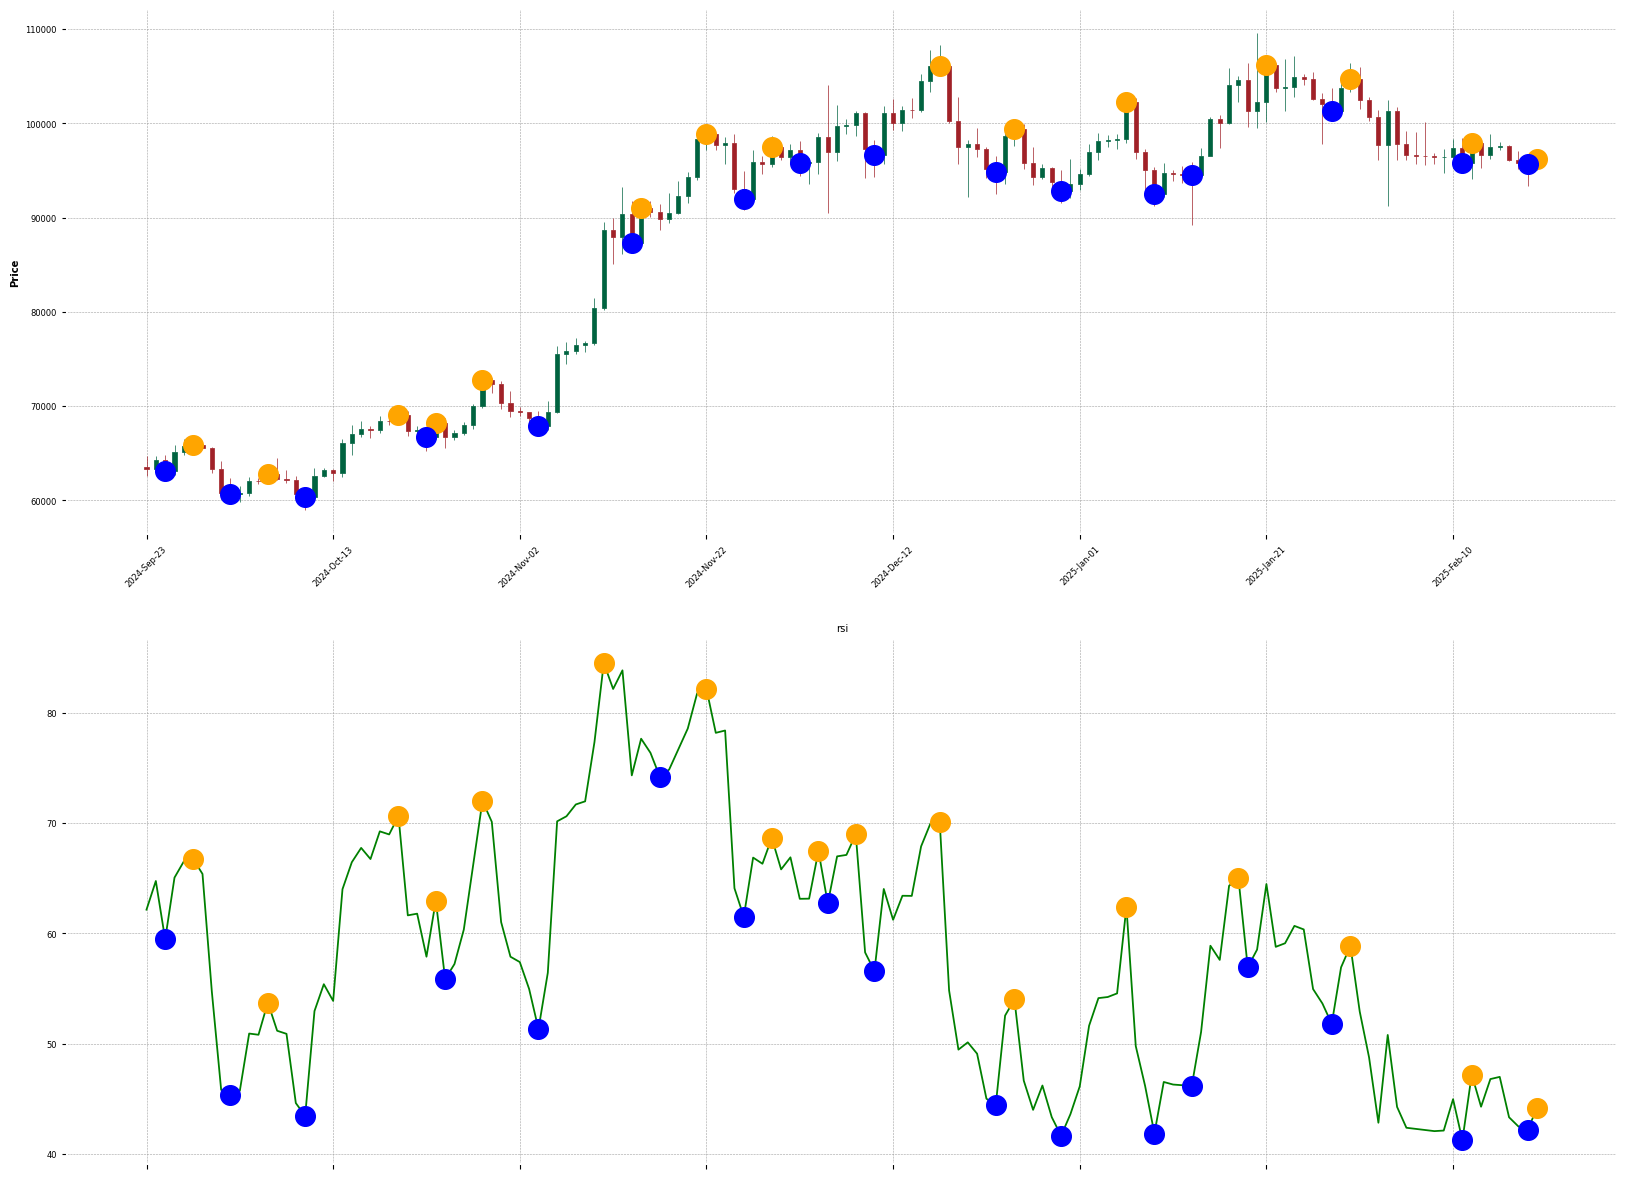

In [32]:
plot_top_bottom(df, INDICATOR_NAME, 450)

In [33]:
df_top = df.copy().loc[df[INDICATOR_NAME+"_top"] == 1]
df_top_indicator = df.copy().loc[df[COMPARATIVE_VALUE+"_top"] == 1]
div_top_obj = get_df_top_divergence(df_top, df_top_indicator, COMPARATIVE_VALUE, INDICATOR_NAME, True, 100)
df_div_top_bull = div_top_obj["top_bull_div"]
df_div_top_bear = div_top_obj["top_bear_div"]

df_bottom = df.copy().loc[df[INDICATOR_NAME+"_bottom"] == 1]
df_bottom_indicator = df.copy().loc[df["close_bottom"] == 1]
div_bottom_obj = get_df_bottom_divergence(df_bottom, df_bottom_indicator, COMPARATIVE_VALUE, INDICATOR_NAME, True, 100)
df_div_bottom_bull = div_bottom_obj["bottom_bull_div"]
df_div_bottom_bear = div_bottom_obj["bottom_bear_div"]

In [34]:
df_div_bottom_bear

,start_date,end_date,start_iloc,end_iloc,start_value,end_value,scope,start_indicator_value,end_indicator_value,indicator_scope
21,2017-10-04,2017-11-12,48,87,4208.59,5811.03,-0.273556,53.048375,42.379686,41.088205
22,2017-10-24,2017-11-12,68,87,5477.03,5811.03,-0.749717,56.624318,42.379686,17.578947
25,2017-11-12,2017-12-30,87,135,5811.03,12440.01,-0.012617,42.379686,41.774073,138.103750
26,2017-11-12,2018-01-16,87,152,5811.03,10900.00,-0.102012,42.379686,35.748932,78.291846
27,2017-11-12,2018-02-05,87,172,5811.03,6939.99,-0.180989,42.379686,26.995652,13.281882
...,...,...,...,...,...,...,...,...,...,...
468,2024-11-26,2024-12-10,2658,2672,91965.16,96593.00,-0.351639,61.503602,56.580656,330.560000
469,2024-11-26,2024-12-23,2658,2685,91965.16,94881.47,-0.632251,61.503602,44.432817,108.011481
472,2024-12-30,2025-02-11,2692,2735,92792.05,95778.20,-0.009489,41.647336,41.239325,69.445349
474,2025-01-09,2025-02-11,2702,2735,92552.49,95778.20,-0.018570,41.852140,41.239325,97.748788


--- 28 Bullish Bottom Divergence detected ---
1 candle after the detection of a bullish bottom divergence we have a mean result of 1.61%
3 candles after the detection of a bullish bottom divergence we have a mean result of 1.88%
5 candles after the detection of a bullish bottom divergence we have a mean result of 1.26%
10 candles after the detection of a bullish bottom divergence we have a mean result of -0.3%
20 candles after the detection of a bullish bottom divergence we have a mean result of 0.81%
50 candles after the detection of a bullish bottom divergence we have a mean result of 8.24%
100 candles after the detection of a bullish bottom divergence we have a mean result of 19.2%


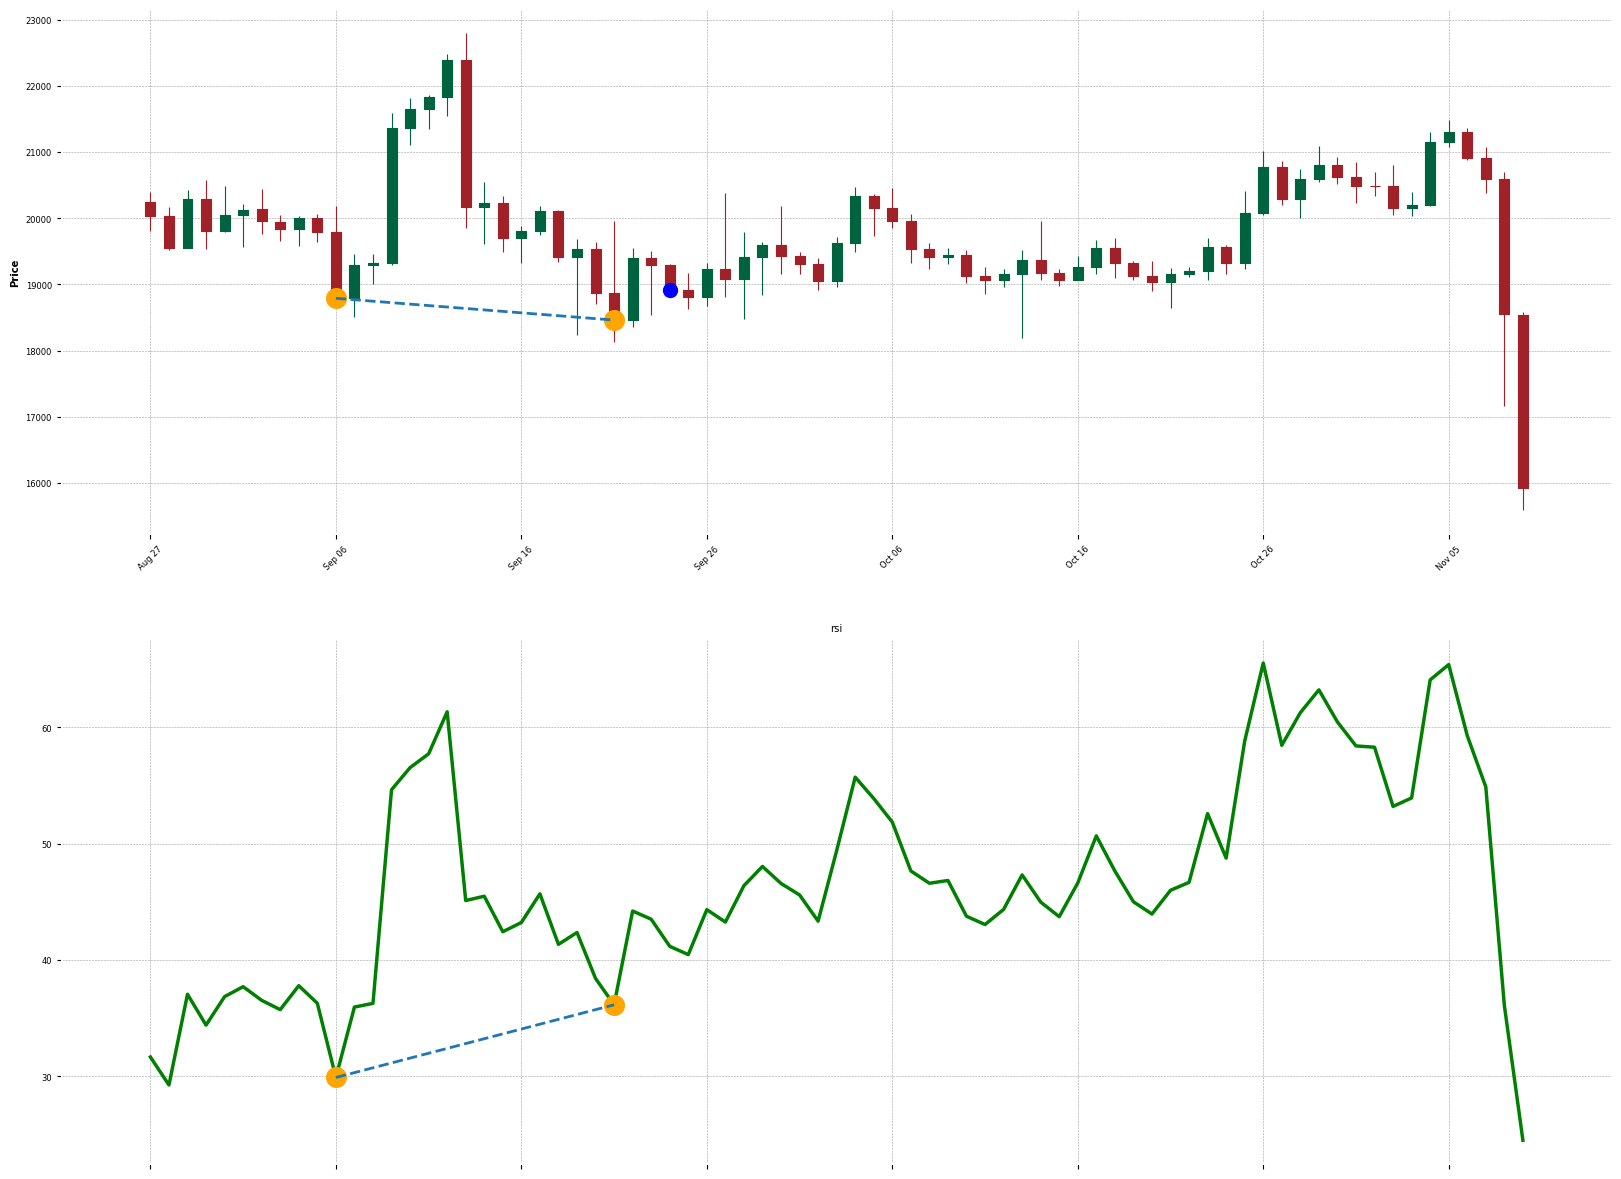

In [22]:
mean_reasult_after_1_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n1_result"] * 100).mean(), 2)
mean_reasult_after_3_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n3_result"] * 100).mean(), 2)
mean_reasult_after_5_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n5_result"] * 100).mean(), 2)
mean_reasult_after_10_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n10_result"] * 100).mean(), 2)
mean_reasult_after_20_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n20_result"] * 100).mean(), 2)
mean_reasult_after_50_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n50_result"] * 100).mean(), 2)
mean_reasult_after_100_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n100_result"] * 100).mean(), 2)

print(f"--- {len(df_div_bottom_bull)} Bullish Bottom Divergence detected ---")
print(f"1 candle after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_1_period}%")
print(f"3 candles after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_3_period}%")
print(f"5 candles after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_5_period}%")
print(f"10 candles after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_10_period}%")
print(f"20 candles after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_20_period}%")
print(f"50 candles after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_50_period}%")
print(f"100 candles after the detection of a bullish bottom divergence we have a mean result of {mean_reasult_after_100_period}%")

plot_div(df, df_div_bottom_bull.iloc[len(df_div_bottom_bull)-10], INDICATOR_NAME, 3, 50)

--- 109 Bearish Bottom Divergence detected ---
1 candle after the detection of a bearish bottom divergence we have a mean result of 0.35%
3 candles after the detection of a bearish bottom divergence we have a mean result of 0.92%
5 candles after the detection of a bearish bottom divergence we have a mean result of 0.81%
10 candles after the detection of a bearish bottom divergence we have a mean result of 2.32%
20 candles after the detection of a bearish bottom divergence we have a mean result of 5.86%
50 candles after the detection of a bearish bottom divergence we have a mean result of 14.84%
100 candles after the detection of a bearish bottom divergence we have a mean result of 25.92%


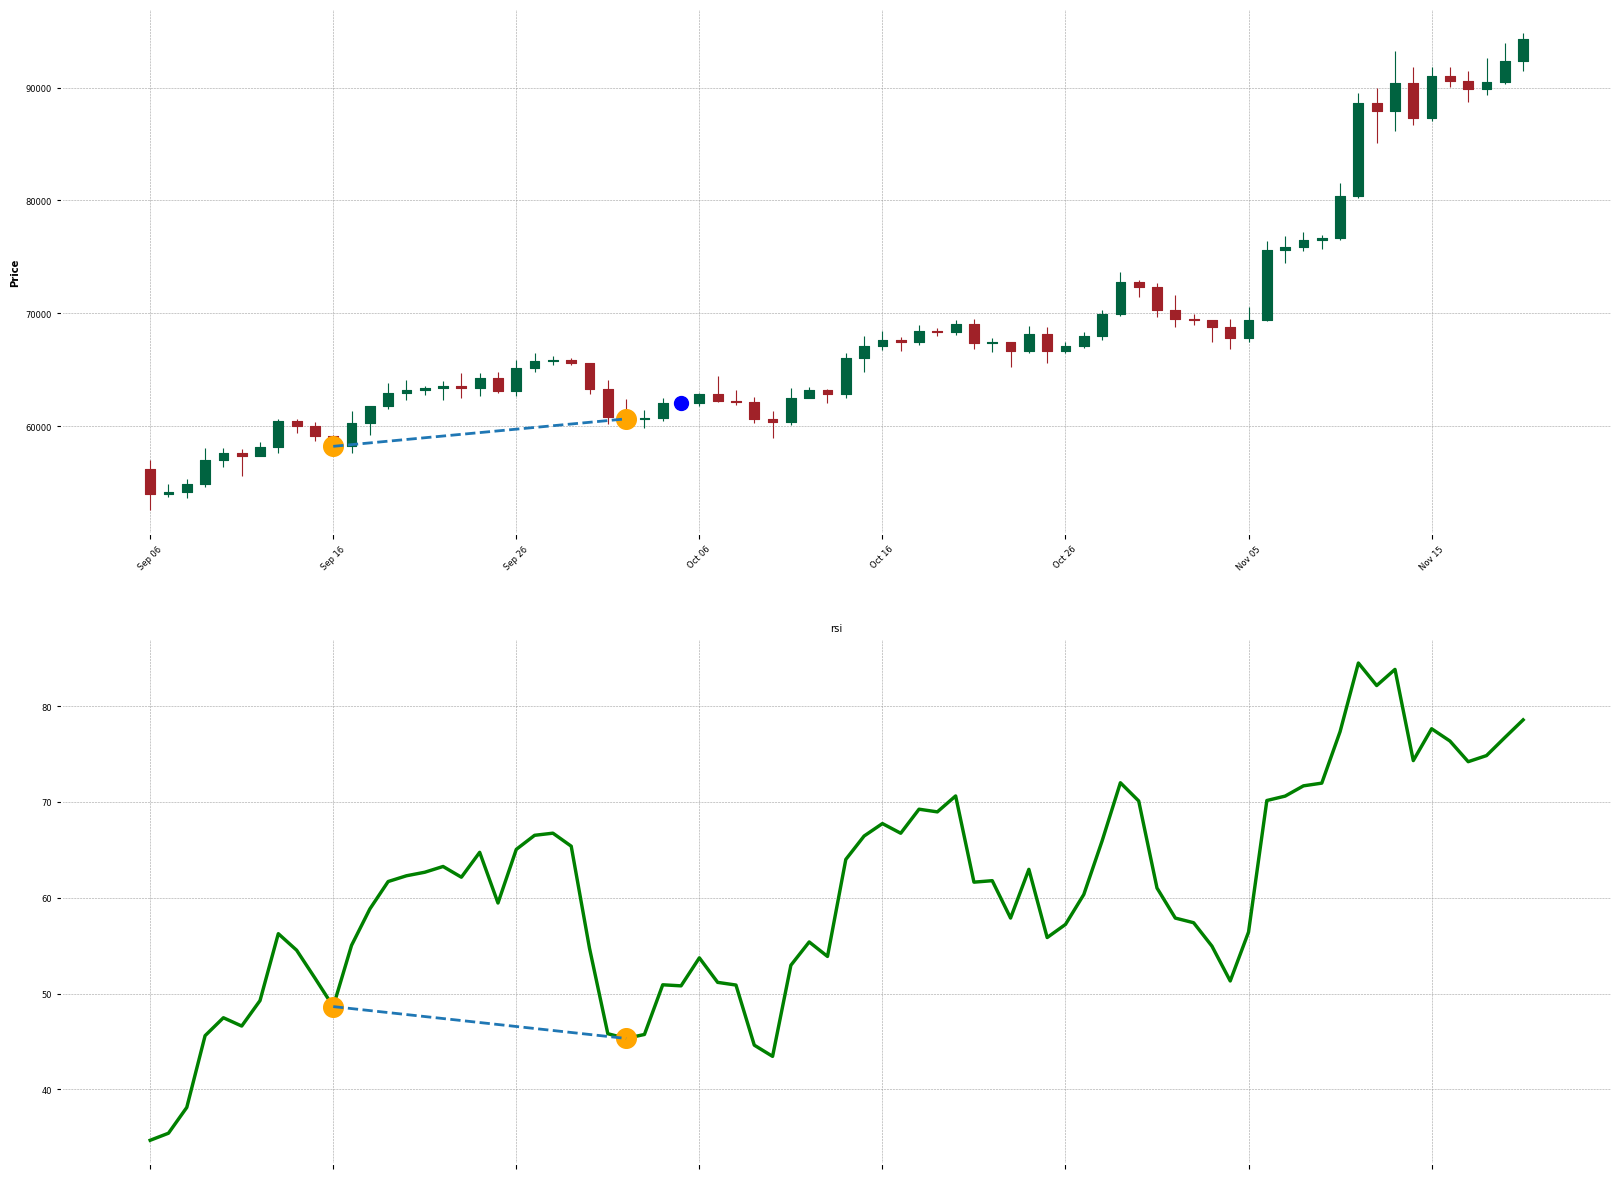

In [23]:
mean_reasult_after_1_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n1_result"] * 100).mean(), 2)
mean_reasult_after_3_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n3_result"] * 100).mean(), 2)
mean_reasult_after_5_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n5_result"] * 100).mean(), 2)
mean_reasult_after_10_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n10_result"] * 100).mean(), 2)
mean_reasult_after_20_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n20_result"] * 100).mean(), 2)
mean_reasult_after_50_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n50_result"] * 100).mean(), 2)
mean_reasult_after_100_period = round((df.loc[df["iloc"].isin(list(df_div_bottom_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n100_result"] * 100).mean(), 2)

print(f"--- {len(df_div_bottom_bear)} Bearish Bottom Divergence detected ---")
print(f"1 candle after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_1_period}%")
print(f"3 candles after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_3_period}%")
print(f"5 candles after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_5_period}%")
print(f"10 candles after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_10_period}%")
print(f"20 candles after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_20_period}%")
print(f"50 candles after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_50_period}%")
print(f"100 candles after the detection of a bearish bottom divergence we have a mean result of {mean_reasult_after_100_period}%")

plot_div(df, df_div_bottom_bear.iloc[len(df_div_bottom_bear)-10], INDICATOR_NAME, 3, 50)

--- 61 Bullish Top Divergence detected ---
1 candle after the detection of a bullish top divergence we have a mean result of 0.26%
3 candles after the detection of a bullish top divergence we have a mean result of 0.32%
5 candles after the detection of a bullish top divergence we have a mean result of 1.4%
10 candles after the detection of a bullish top divergence we have a mean result of -1.13%
20 candles after the detection of a bullish top divergence we have a mean result of 1.35%
50 candles after the detection of a bullish top divergence we have a mean result of 4.77%
100 candles after the detection of a bullish top divergence we have a mean result of 15.77%


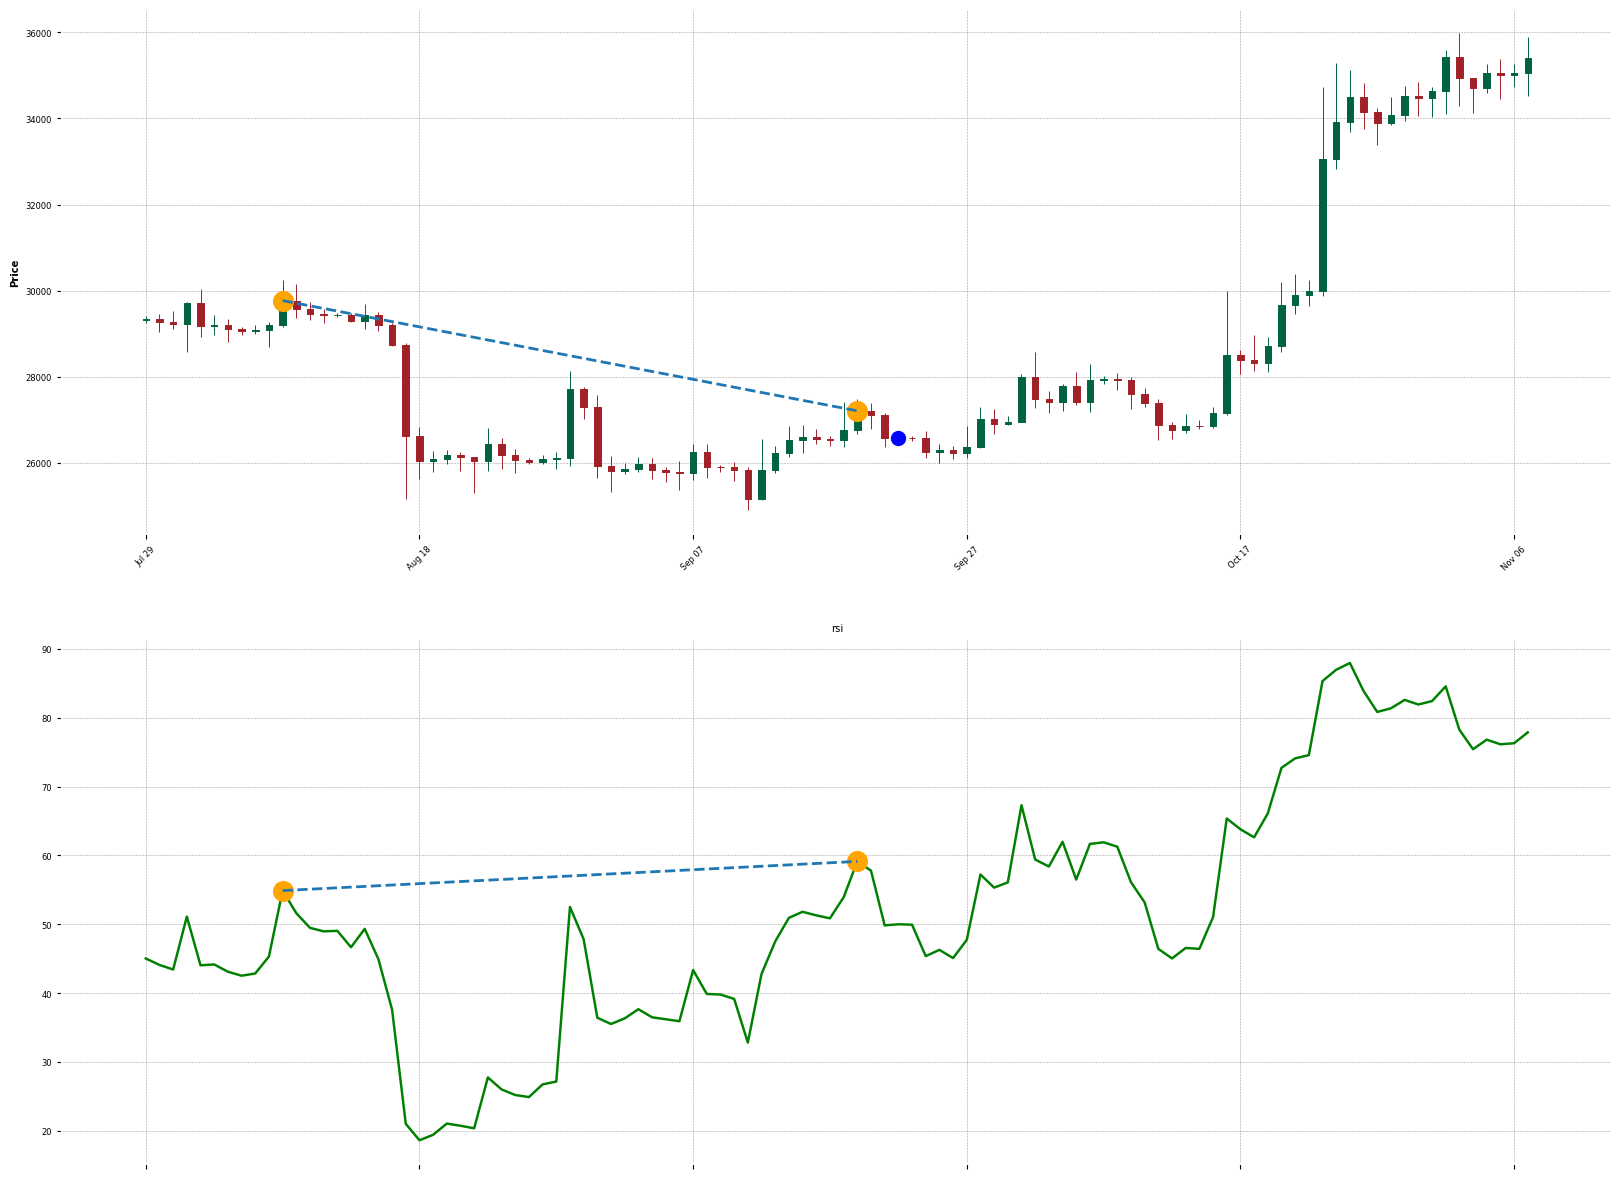

In [24]:
mean_reasult_after_1_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n1_result"] * 100).mean(), 2)
mean_reasult_after_3_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n3_result"] * 100).mean(), 2)
mean_reasult_after_5_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n5_result"] * 100).mean(), 2)
mean_reasult_after_10_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n10_result"] * 100).mean(), 2)
mean_reasult_after_20_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n20_result"] * 100).mean(), 2)
mean_reasult_after_50_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n50_result"] * 100).mean(), 2)
mean_reasult_after_100_period = round((df.loc[df["iloc"].isin(list(df_div_top_bull["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n100_result"] * 100).mean(), 2)

print(f"--- {len(df_div_top_bull)} Bullish Top Divergence detected ---")
print(f"1 candle after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_1_period}%")
print(f"3 candles after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_3_period}%")
print(f"5 candles after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_5_period}%")
print(f"10 candles after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_10_period}%")
print(f"20 candles after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_20_period}%")
print(f"50 candles after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_50_period}%")
print(f"100 candles after the detection of a bullish top divergence we have a mean result of {mean_reasult_after_100_period}%")

plot_div(df, df_div_top_bull.iloc[len(df_div_top_bull) - 10], INDICATOR_NAME, 3, 50)

--- 41 Bearish Top Divergence detected ---
1 candle after the detection of a bearish top divergence we have a mean result of -0.6%
3 candles after the detection of a bearish top divergence we have a mean result of -0.19%
5 candles after the detection of a bearish top divergence we have a mean result of 0.07%
10 candles after the detection of a bearish top divergence we have a mean result of 2.64%
20 candles after the detection of a bearish top divergence we have a mean result of 7.38%
50 candles after the detection of a bearish top divergence we have a mean result of 10.38%
100 candles after the detection of a bearish top divergence we have a mean result of 18.67%


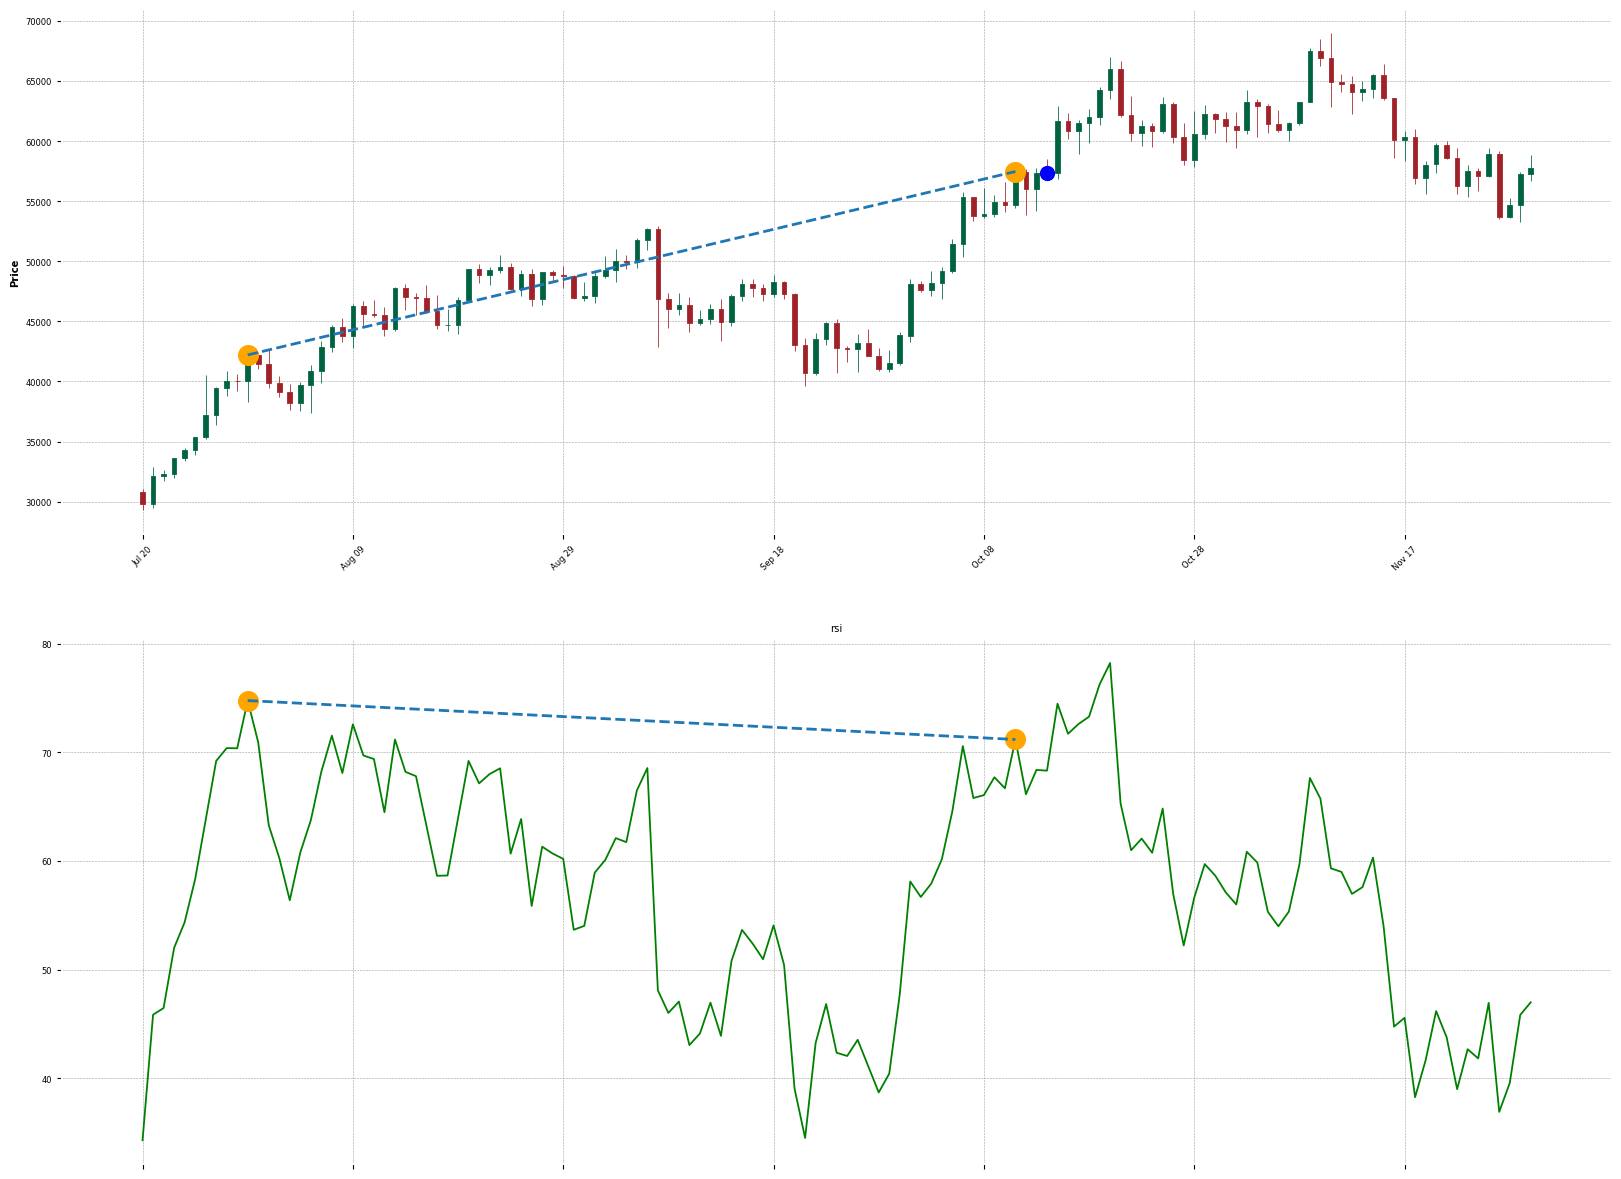

In [26]:
mean_reasult_after_1_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n1_result"] * 100).mean(), 2)
mean_reasult_after_3_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n3_result"] * 100).mean(), 2)
mean_reasult_after_5_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n5_result"] * 100).mean(), 2)
mean_reasult_after_10_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n10_result"] * 100).mean(), 2)
mean_reasult_after_20_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n20_result"] * 100).mean(), 2)
mean_reasult_after_50_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n50_result"] * 100).mean(), 2)
mean_reasult_after_100_period = round((df.loc[df["iloc"].isin(list(df_div_top_bear["end_iloc"] + TOP_WINDOW_DETECTION + 1))]["n100_result"] * 100).mean(), 2)

print(f"--- {len(df_div_top_bear)} Bearish Top Divergence detected ---")
print(f"1 candle after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_1_period}%")
print(f"3 candles after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_3_period}%")
print(f"5 candles after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_5_period}%")
print(f"10 candles after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_10_period}%")
print(f"20 candles after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_20_period}%")
print(f"50 candles after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_50_period}%")
print(f"100 candles after the detection of a bearish top divergence we have a mean result of {mean_reasult_after_100_period}%")

plot_div(df, df_div_top_bear.iloc[len(df_div_top_bear) - 20], INDICATOR_NAME, 3, 50)